In [2]:
import argparse
import torch
import torch.nn as nn
import torch.utils.data
import torchvision.utils as vutils
import torchsummary
import torchvision.datasets as dset
from torch.nn import Parameter
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from math import sqrt
from torch.autograd import grad
from scipy.stats import truncnorm

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### Dataset
Download datset

In [4]:
zip_path = '/content/drive/My Drive/Thesis/cover.zip'
!cp "{zip_path}" .
!unzip -q cover.zip
!rm cover.zip

replace cover/test/blues/738bf445-efbb-46c9-b5b6-39aa84001ec9-0__16188be5-6458-4a95-af7d-7a98d9f23cbe.jpg__0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


And let's create the dataloader from the dataset downloaded

In [5]:
batch = 64

dataroot = 'cover/train'
train_dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

torch.save(train_dataset, 'train_dataset_128_norm_mixed.pt')
train_dataset = torch.load('train_dataset_128_norm_mixed.pt')
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch, drop_last=True)


### Classes definition
Generator and discriminator class. We also declare a function for weight initialization

In [11]:
class Generator(nn.Module):
    def __init__(self, nz, ngf):
        super(Generator,self).__init__()

        self.lin = nn.Linear(nz, ngf*4*4*4)
        self.bn = nn.BatchNorm2d(ngf*4)
        self.tconv1 = nn.ConvTranspose2d(ngf*4, ngf*4, 4, 2, 1)
        self.bn1 = nn.BatchNorm2d(ngf*4)
        self.tconv2 = nn.ConvTranspose2d(ngf*4, ngf*4, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(ngf*4)
        self.tconv3 = nn.ConvTranspose2d(ngf*4, ngf*4, 4, 2, 1)
        self.bn3 = nn.BatchNorm2d(ngf*4)
        self.tconv4 = nn.ConvTranspose2d(ngf*4, ngf*4, 3, 1, 1)
        self.bn4 = nn.BatchNorm2d(ngf*4)
        self.tconv5 = nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1)
        self.bn5 = nn.BatchNorm2d(ngf*2)
        self.tconv6 = nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1)
        self.bn6 = nn.BatchNorm2d(ngf)
        self.tconv7 = nn.ConvTranspose2d(ngf, 3, 4, 2, 1)

        self.relu = nn.ReLU(True)
        self.tanh = nn.Tanh()
        self.ngf = ngf

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.lin(x)
        x = self.bn(x.view(x.size(0), self.ngf*4, 4, 4))
        x = self.relu(self.bn1(self.tconv1(x)))
        x = self.relu(self.bn2(self.tconv2(x)))
        x = self.relu(self.bn3(self.tconv3(x)))
        x = self.relu(self.bn4(self.tconv4(x)))
        x = self.relu(self.bn5(self.tconv5(x)))
        x = self.relu(self.bn6(self.tconv6(x)))
        x = self.tanh(self.tconv7(x))

        return x


class Discriminator (nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()    
        self.conv1 = nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)
        self.in1 = nn.InstanceNorm2d(ndf, affine=True)
        self.conv2 = nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False)
        self.in2 = nn.InstanceNorm2d(ndf*2, affine=True)
        self.conv3 = nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False)
        self.in3 = nn.InstanceNorm2d(ndf*4, affine=True)
        self.conv4 = nn.Conv2d(ndf*4, ndf*4, 4, 2, 1, bias=False)
        self.in4 = nn.InstanceNorm2d(ndf*4, affine=True)
        self.conv5 = nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False)
        self.in5 = nn.InstanceNorm2d(ndf*8, affine=True)
        self.lin = nn.Linear(ndf*8*4*4, 1)

        self.leakyrelu = nn.LeakyReLU(0.2, inplace=True)

    def forward (self, x):
        x = self.leakyrelu(self.in1(self.conv1(x)))
        x = self.leakyrelu(self.in2(self.conv2(x)))
        x = self.leakyrelu(self.in3(self.conv3(x)))
        x = self.leakyrelu(self.in4(self.conv4(x)))
        x = self.leakyrelu(self.in5(self.conv5(x)))
        x = self.lin(x.view(x.size(0), -1))

        return x


# Weight initialization function
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('_bar') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# Summary of discriminator architecture
ndf = 64
ngf = 64
nz = 100
model = Discriminator(3,ndf)
torchsummary.summary(model.to('cuda:0'),(3,128,128)) 

# Summary of generator architecture
model = Generator(nz,ngf)
torchsummary.summary(model.to('cuda:0'),(nz,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           3,072
    InstanceNorm2d-2           [-1, 64, 64, 64]             128
         LeakyReLU-3           [-1, 64, 64, 64]               0
            Conv2d-4          [-1, 128, 32, 32]         131,072
    InstanceNorm2d-5          [-1, 128, 32, 32]             256
         LeakyReLU-6          [-1, 128, 32, 32]               0
            Conv2d-7          [-1, 256, 16, 16]         524,288
    InstanceNorm2d-8          [-1, 256, 16, 16]             512
         LeakyReLU-9          [-1, 256, 16, 16]               0
           Conv2d-10            [-1, 256, 8, 8]       1,048,576
   InstanceNorm2d-11            [-1, 256, 8, 8]             512
        LeakyReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 512, 4, 4]       2,097,152
   InstanceNorm2d-14            [-1, 51

### Models and optimizers intialization

In [13]:
# Define device as the available hardware
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

torch.manual_seed(4)

ndf = 64
ngf = 64
nz = 100
nc = 3

model_g = Generator(nz, ngf)
model_d = Discriminator(nc, ndf)

model_g.to(device)
model_d.to(device)

model_g.apply(weights_init)
model_d.apply(weights_init)

Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (in1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (in2): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (in3): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (conv4): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (in4): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (conv5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (in5): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (lin): Linear(in_features=8192, out_features=1, bias=True)
  (l

In [14]:
lr_g = 1e-4
lr_d = 1e-4
weight_decay = 0
optimizer_D = torch.optim.Adam(model_d.parameters(), lr=lr_d, weight_decay=weight_decay, betas=(0,0.999))
optimizer_G = torch.optim.Adam(model_g.parameters(), lr=lr_g, weight_decay=weight_decay, betas=(0,0.999))

### Training

In [ ]:
nc = 3       # Number of channels in training images
ndf = 64     # Size of feature maps in discriminator
ngf = 64     # Size of feature maps in generator
nz = 100     # Latent space size


real_label = torch.Tensor(batch, 1).fill_(1.0)
fake_label = torch.Tensor(batch, 1).fill_(0.0)

epochs = 300
cost_d=[]
cost_g=[]
img_list = []
epoch = 0
it = 0
lambda_reg = 10

checkpoint=False
if checkpoint:
  checkpoint = torch.load('/content/drive/My Drive/Towards_album_artwork_generation_based_on_audio/models/wgan_gp.pt', map_location=lambda storage, loc: storage)
  model_d.load_state_dict(checkpoint['model_d'])
  model_g.load_state_dict(checkpoint['model_g'])
  cost_d = checkpoint['cost_d']
  cost_g = checkpoint['cost_g']
  epoch = checkpoint['epoch']
  it = len(cost_d)

one = torch.tensor(1, dtype=torch.float).to(device)
mone = -1*one
n_critic = 5


for epoch in range(epoch, epoch+epochs):
    for i, img in enumerate(train_loader,1):
        it+=1
        real_imgs, _ = img

        #Train D
        for d_iter in range(n_critic):
          optimizer_D.zero_grad()
          # Train real score
          real_score = model_d(real_imgs.to(device))
          loss_D_real = -real_score.mean()
          loss_D_real.backward()

          # Train fake score
          noise = torch.randn(batch, nz).to(device)
          fake_data = model_g(noise)
          fake_score = model_d(fake_data.detach())
          loss_D_fake = fake_score.mean()
          loss_D_fake.backward()

          # Train with gradient penalty
          b = real_imgs.shape[0]
          epsilon = torch.rand(b, 1, 1, 1).to(device)
          # sample x_hat 
          x_hat = (epsilon * real_imgs.to(device) + (1 - epsilon) * fake_data).requires_grad_(True)         
          Dx_hat = model_d(x_hat)
          musk = torch.ones_like(Dx_hat)
          gradients = torch.autograd.grad(Dx_hat, x_hat, grad_outputs=musk, retain_graph=True, create_graph=True, allow_unused=True)[0]
          gradients = gradients.reshape(-1, 1)
          gradient_penalty = lambda_reg * ((gradients.norm(2, dim=1) - 1) ** 2).mean()
          gradient_penalty.backward()          

          #Update weights
          loss_D = -(loss_D_real - loss_D_fake) + gradient_penalty
          Wasserstein_D = -(loss_D_real - loss_D_fake)
          optimizer_D.step()

        #Train G
        fake_data = model_g(noise)
        D_fake = model_d(fake_data)   
        loss_G = -D_fake.mean()
        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

        # Save losses
        cost_d.append(loss_D)
        cost_g.append(loss_G)

        # Print losses      
        if i % 5 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tWasserstein_distance: %.4f\tLoss_G: %.4f'
                  % (epoch, epochs, i, len(train_loader), loss_D, Wasserstein_D, loss_G))


    # Check how the generator is doing by saving G's output noise and 
    # truncated noise
    model_g.eval()
    trunc_noise = torch.FloatTensor(truncnorm.rvs(-1.5, 1.5, size=nz*batch))
    trunc_noise = trunc_noise.view(batch, nz)

    # Save generated images from noise
    with torch.no_grad():
        fake = model_g(trunc_noise.to(device)).detach().cpu()
    img_list_trunc.append(vutils.make_grid(fake, padding=2, normalize=True))
    vutils.save_image(img_list_trunc, '/content/drive/My Drive/wgan_gp_noise_imgs_'+str(epoch)+'.jpg')

    # Save generated images from truncated noise
    with torch.no_grad():
        fake = model_g(noise.to(device)).detach().cpu()
    img_list_noise.append(vutils.make_grid(fake, padding=2, normalize=True))
    vutils.save_image(img_list_noise, '/content/drive/My Drive/wgan_gp_trunc_imgs_'+str(epoch)+'.jpg')
    model_g.train()

    # Plot generator and discriminator loss
    plt.figure()
    plt.plot(cost_d, label='discriminator')
    plt.plot(cost_d)
    plt.plot(cost_g, label='generator')
    plt.legend()

    # Save models and more info
    torch.save(
        {'model_d': model_d.state_dict(),
         'model_g': model_g.state_dict(),
         'epoch': epoch,
         'optimizer_d': optimizer_D.state_dict(),
         'optimizer_g': optimizer_G.state_dict(),
         'cost_d': cost_d,
         'cost_g': cost_g,
         'iter': it}, '/content/drive/My Drive/wgan_gp_'+str(epoch)+'.pt')

### Analysis
Let's now analyze the generated outputs from the trained model

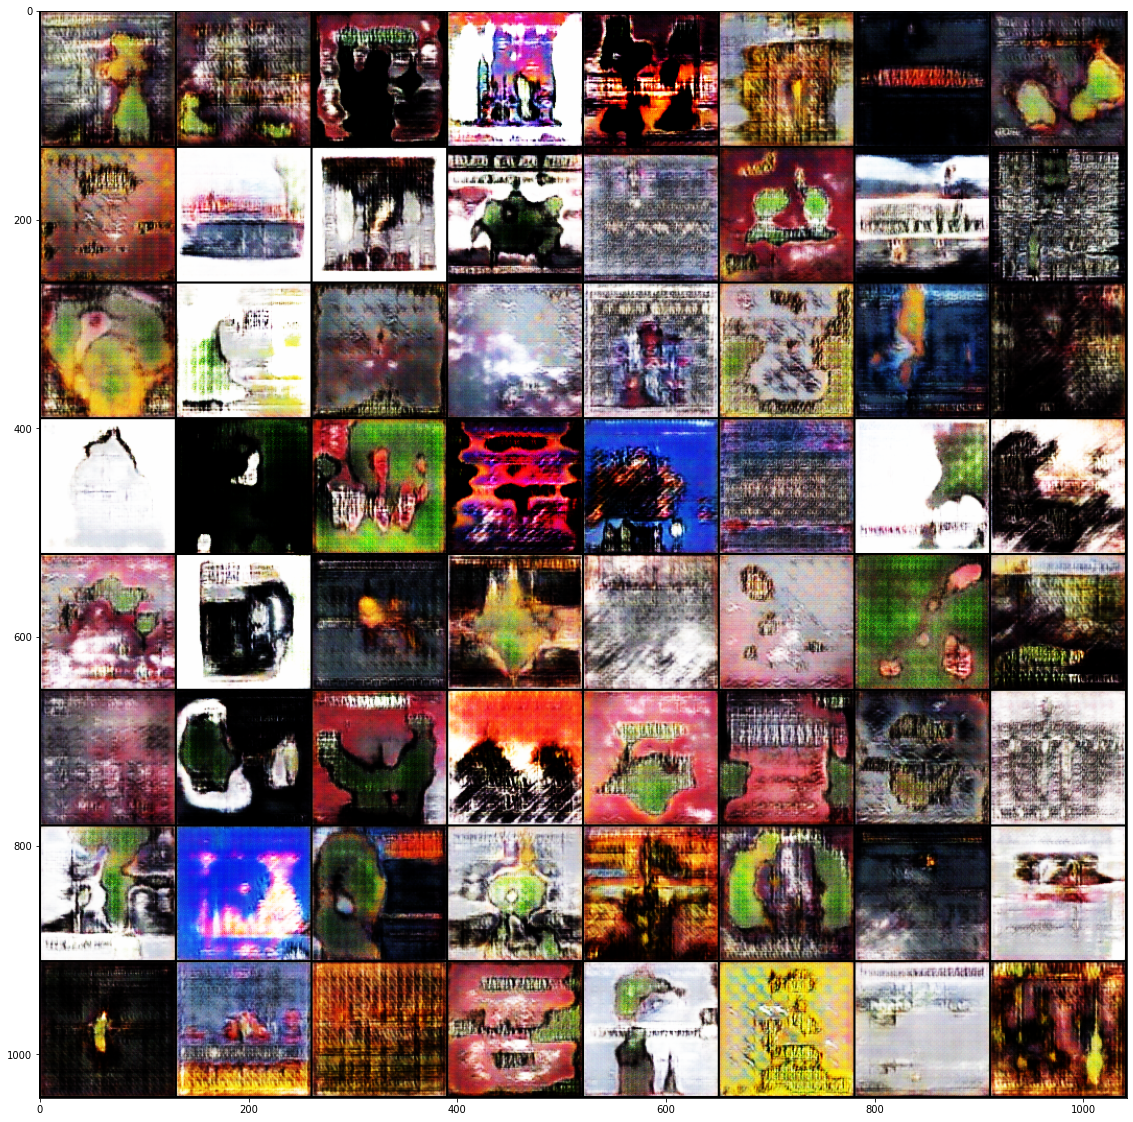

In [18]:
import numpy as np

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

nz = 100            # latent vector
ngf = 64           # Size of feature maps in generator
ndf = 64            # Size of feature maps in discriminator

model_g = Generator(nz, ngf)
model_g.to(device)

checkpoint = torch.load('/content/drive/My Drive/Towards_album_artwork_generation_based_on_audio/models/wgan_gp.pt', map_location=lambda storage, loc: storage)
model_g.load_state_dict(checkpoint['model_g'])

noise = torch.randn(64, nz)

plt.figure(figsize=(20,20))
with torch.no_grad():
    fake = model_g(noise.to(device)).detach().cpu()
plt.imshow(np.transpose(vutils.make_grid(fake.to(device)[:128], padding=2, normalize=True).cpu(),(1,2,0)))